# Predicting Airfoil Aerodynamics through data
by Raul Carreira Rufato and Prof. Joseph Morlier

This notebook is a tutorial to determine the aerodynamic coefficients of a given airfoil using SMT. The obtained surrogate model can be used to give predictions for certain Mach numbers, angles of attack and the aerodynamic coefficients. These calculations can be really usefull in case of an airfoil shape optimization. The input parameters uses the airfoil Camber and Thickness mode shapes.

**Inputs:** Airfoil Camber and Thickness mode shapes, Mach, alpha

**Outputs (options):** cd, cl, cm

In this test case, we will be predicting only the Cd coefficient. However, the other databases for the prediction of the other terms are available in the same repository.

**Bouhlel's mSANN in a nutshell:**

a. Using inverse distance weighting (IDW) to interpolate the surface function of each airfoil.

b. Then applying singular value decomposition (SVD) to reduce the number of variables that define the airfoil geometry. It includes a total of 14 airfoil modes (seven for camber and seven for thickness).

c. Totally 16 input variables, two flow conditions of Mach number (0.3 ~ 0.6) and the angle of attack
(2 ◦ ~ 6◦) plus 14 shape coefficients.

d. The output airfoil aerodynamic force coefficients and their respective gradients are computed using ADflow, which solves the RANS equations with a Spalart–Allmaras turbulence model.
 







**[1]** Bouhlel, M. A., He, S., and Martins, J. R. R. A., “mSANN Model Benchmarks,” Mendeley Data, 2019. https://doi.org/10. 17632/ngpd634smf.1. 

**[2]**  Li, J., Bouhlel,M., and Martins,J.R.R.A., “Data-Based Approach for Fast Airfoil Analysis. and Optimization,”AIAA Journal, 2019. 

**[3]**  Bouhlel, M.A., and Martins,J.R.R.A.,“Gradient-EnhancedKrigingforHigh-DimensionalProblems,”Springer-Verlag,2018. 

**[4]** Bouhlel,M., He,S., and Martins,J.R.R.A.,“Scalable Gradient-Enhanced Artificial Neural Networks for Airfoil Shape Design in the Subsonic and Transonic Regimes,” ResearchGate, 2020.

**[5]** Du,X.,He,P.,and Martins,J.,“Rapid airfoil design optimization via neuralnetworks-basedp arameterization and surrogate modeling,” Elsevier, 2021. 

**[6]**  University of Michigan, “Webfoil,” 2021. URL http://webfoil.engin.umich.edu/, online accessed on 16/06/2021. 



In [ ]:
!pip install smt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 252 kB 17.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 539 kB/s 
     |████████████████████████████████| 3.1 MB 62.5 MB/s 
     |████████████████████████████████| 90 kB 12.9 MB/s 
     |████████████████████████████████| 121 kB 73.2 MB/s 
     |████████████████████████████████| 100 kB 13.4 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
  Created wheel for smt: filename=smt-1.2.0-cp37-cp37m-linux_x86_64.whl size=527879 sha256=1625b905b97ab34f43e8f2e90eb28650f4c525cecb7a7838f6f349a08a9ea8d7
  Stored in directory: /root/.cache/pip/wheels/3d/69/1e/ae0014b43757c2db9bdd61fdae3a4f532f9d64c451a1bc678e
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256=e7005a7d96ee2a94f18b687026

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models.genn import GENN, load_smt_data
import csv
from sklearn.model_selection import train_test_split 
import pickle

In [ ]:
#getting datasets
def getData():
  try :
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    json_import = drive.CreateFile({'id':'12YxH73HHy7lKzM69LqcG_baXRlso82nR'})
    json_import.GetContentFile('dataSMTCd.json')
    json_import = drive.CreateFile({'id':'1WQDKH51TfGFg4WeWQgHjPlLSm6NsXJY-'})
    json_import.GetContentFile('DataDySMTCd.json')
    # gets the input vector and the outputs
    # data from the Database:
    # Bouhlel, M. A., He, S., and Martins, J. R. R. A., “mSANN Model Benchmarks,” Mendeley Data, 2019. https://doi.org/10.17632/ngpd634smf.1
    # dataset different from Keras one: some derivatives were missing
    with open('dataSMTCd.json') as file:
        reader = csv.reader(file, delimiter=";")
        values = np.array(list(reader), dtype = np.float32)
        dim_values = values.shape
        x = values[:,:dim_values[1]-1]
        y = values[:,-1]
    # gets the gradient information
    # data from the Database:
    # Bouhlel, M. A., He, S., and Martins, J. R. R. A., “mSANN Model Benchmarks,” Mendeley Data, 2019. https://doi.org/10.17632/ngpd634smf.1
    with open ('DataDySMTCd.json') as file:
        reader = csv.reader(file, delimiter=";")
        dy = np.array(list(reader), dtype = np.float32)
  except :
    with open('dataSMTCd.csv') as file:
        reader = csv.reader(file, delimiter=";")
        values = np.array(list(reader), dtype = np.float32)
        dim_values = values.shape
        x = values[:,:dim_values[1]-1]
        y = values[:,-1]
    with open ('DataDySMTCd.csv') as file:
        reader = csv.reader(file, delimiter=";")
        dy = np.array(list(reader), dtype = np.float32)
  return x, y, dy             

In [ ]:
x, y, dy = getData()

In [ ]:
# splitting the dataset
x_train, x_test, y_train, y_test, dy_train, dy_test = train_test_split(x, y, dy, train_size= 0.8)

# building and training the GENN
genn = GENN()
genn.options["alpha"] = 0.001  # learning rate that controls optimizer step size
genn.options[
    "lambd"
] = 0.1  # lambd = 0. = no regularization, lambd > 0 = regularization
genn.options[
    "gamma"
] = 1.0  # gamma = 0. = no grad-enhancement, gamma > 0 = grad-enhancement
genn.options["deep"] = 2  # number of hidden layers
genn.options["wide"] = 6  # number of nodes per hidden layer
genn.options[
    "mini_batch_size"
] = 256  # used to divide data into training batches (use for large data sets)
genn.options["num_epochs"] = 25  # number of passes through data
genn.options[
    "num_iterations"
] = 10  # number of optimizer iterations per mini-batch
genn.options["is_print"] = True  # print output (or not)
load_smt_data(
    genn, x_train, y_train, dy_train
)  # convenience function to read in data that is in SMT format
genn.train()

___________________________________________________________________________
   
                                   GENN
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 33631
   
___________________________________________________________________________
   
 Training
   
   Training ...
epoch = 0, mini-batch = 0, avg cost =  3.337
epoch = 0, mini-batch = 1, avg cost =  4.315
epoch = 0, mini-batch = 2, avg cost =  3.558
epoch = 0, mini-batch = 3, avg cost =  2.778
epoch = 0, mini-batch = 4, avg cost =  2.648
epoch = 0, mini-batch = 5, avg cost =  2.845
epoch = 0, mini-batch = 6, avg cost =  1.728
epoch = 0, mini-batch = 7, avg cost =  2.896
epoch = 0, mini-batch = 8, avg cost =  3.506
epoch = 0, mini-batch = 9, avg cost =  1.578
epoch = 0, mini-batch = 10, avg cost =  2.182
epoch = 0, mini-batch = 11, avg cost =  2.424
epoch = 0, mini-batch = 12, avg cost =  2.905
epoch = 0, mini-batch = 13, avg cost =  

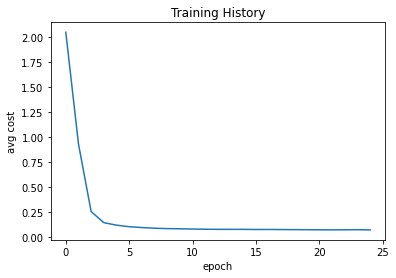

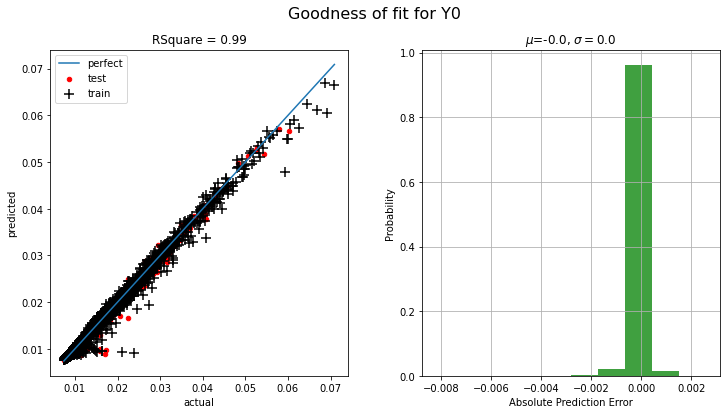

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 8408
   
   Predicting ...
   Predicting - done. Time (sec):  0.0209801
   
   Prediction time/pt. (sec) :  0.0000025
   


In [ ]:
genn.plot_training_history()  # non-API function to plot training history (to check convergence)
genn.goodness_of_fit(
    x_test, y_test, dy_test
)  # non-API function to check accuracy of regression
y_pred = genn.predict_values(
    x_test
)  # API function to predict values at new (unseen) points



In [ ]:
def graphPredictionsSMT(airfoil_modeshapes, airfoil_name, Ma, plot: bool,genn):
    #loading of the models   
    modelcd = genn

    #input arrays are created -> alpha is linearily distributed over the range of -2 to 6 degrees while Ma is kept constant
    input_array = np.zeros(shape = (1,15))
    input_array[0,:14] = airfoil_modeshapes
    input_array[0,-1] = Ma
    new_input_array = np.zeros(shape = (1,15))
    new_input_array[0,:14] = airfoil_modeshapes
    new_input_array[0,-1] = Ma
    for i in range(0,49):
        new_input_array = np.concatenate((new_input_array, input_array), axis = 0)
    alpha = np.zeros(shape = (50,1))
    for i in range(0,50):
        alpha[i,0]= -2 + 0.16* i
    input_array = np.concatenate((new_input_array, alpha), axis = 1)

    # predictions are made
    cd_pred = modelcd.predict_values(input_array)

    # graphs for the single aerodynamic coefficients are computed -> through bool: plot it is to decide if graphs are computed or not
    if plot == True:
        x, y_comp = reconstruct_airfoil(airfoil_modeshapes)
        plt.plot(x, y_comp)
        plt.axis([-0.1,1.2,-0.6,0.6])
        plt.grid(True)
        plt.title(airfoil_name)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.savefig(f"Airfoil_{airfoil_name}")
        plt.close()

        plt.plot(alpha, cd_pred)
        plt.grid(True)
        plt.title("Drag coefficient SMT")
        plt.xlabel("Alpha")
        plt.ylabel("Cd")
        plt.savefig(f"SMT_Cd_{airfoil_name}")
        plt.close() 
    # array for the aerodynamic coeffs and alpha and the airfoil name
    return cd_pred, alpha, airfoil_name


Now we will use the trained model to make a prediction with an unlearned form.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
# to get predictions first the models must be trained and saved
# all links must be changed to your file path
# airfoil_modeshapes: computed mode_shapes of random airfol geometry with parameterise_airfoil
# Ma: desired Mach number for evaluation in range [0.3,0.6]
# gives a scalar prediction using the models trained in SMT
# alpha scalar in range [-1, 6]
def scalarPredictionsSMT(airfoil_modeshapes, Ma, alpha,genn):
    #loading of the models (not yet a direct function in SMT, that is why the way over pickle)
    modelcd = genn

    # input array in neural network is created out of airfoil mode shapes, Mach number and alpha
    input_array = np.zeros(shape=(1,16))
    input_array[0,:14] = airfoil_modeshapes
    input_array[0,14] = Ma
    input_array[0,-1] = alpha

    # predictions are made
    cd_pred = modelcd.predict_values(input_array)

    return cd_pred

# gives an array of predicted aerodynamic coefficients
# plot: bool if graph should be created or not -> if None; just returns the arrays for the aerodynamic coefficients
# airfoil_name: string 
# alpha scalar in range [-1, 10]
def graphPredictionsSMT(airfoil_modeshapes, airfoil_name, Ma, plot: bool,genn):
    #loading of the models   
    modelcd = genn

    #input arrays are created -> alpha is linearily distributed over the range of -1 to 7 degrees while Ma is kept constant
    input_array = np.zeros(shape = (1,15))
    input_array[0,:14] = airfoil_modeshapes
    input_array[0,-1] = Ma
    new_input_array = np.zeros(shape = (1,15))
    new_input_array[0,:14] = airfoil_modeshapes
    new_input_array[0,-1] = Ma
    for i in range(0,49):
        new_input_array = np.concatenate((new_input_array, input_array), axis = 0)
    alpha = np.zeros(shape = (50,1))
    for i in range(0,50):
        alpha[i,0]= -1 + 0.16* i
    input_array = np.concatenate((new_input_array, alpha), axis = 1)

    # predictions are made
    cd_pred = modelcd.predict_values(input_array)

    try :
      from pydrive.auth import GoogleAuth
      from pydrive.drive import GoogleDrive
      from google.colab import auth
      from oauth2client.client import GoogleCredentials

      # 1. Authenticate and create the PyDrive client.
      auth.authenticate_user()
      gauth = GoogleAuth()
      gauth.credentials = GoogleCredentials.get_application_default()
      drive = GoogleDrive(gauth)
      json_import = drive.CreateFile({'id':'1dH8_i98cIeVqlYZHkh0ELYjlOXjNhCGg'})
      json_import.GetContentFile('NACA4412-ADflow-alpha-cd.json')
      json_import = drive.CreateFile({'id':'18q52xShINv24mWdNFiVqVE7NKdMQBiCR'})
      json_import.GetContentFile('NACA4412-XFOIL-alpha-cd.json')

      cd_adflow = pd.read_csv(open("NACA4412-ADflow-alpha-cd.json"),sep=" ")  
      cd_xfoil = pd.read_csv(open("NACA4412-XFOIL-alpha-cd.json"),sep=" ")
    except:
      cd_adflow = pd.read_csv(open("NACA4412-ADflow-alpha-cd.csv"),sep=" ")  
      cd_xfoil = pd.read_csv(open("NACA4412-XFOIL-alpha-cd.csv"),sep=" ")
    # cd from ADflow and Xfoil

    # graphs for the single aerodynamic coefficients are computed -> through bool: plot it is to decide if graphs are computed or not
    if plot == True:
        x, y_comp = reconstruct_airfoil(airfoil_modeshapes)
        plt.figure()
        plt.plot(x, y_comp)
        plt.axis([-0.1,1.2,-0.6,0.6])
        plt.grid(True)
        plt.title(airfoil_name)
        plt.xlabel("x")
        plt.ylabel("y")


        plt.figure()
        plt.plot(alpha, cd_pred)
        plt.plot(cd_adflow.alpha.values[0:9],cd_adflow.cd.values[0:9])
        plt.grid(True)
        plt.legend(['Surrogate','ADflow'])
        plt.title("Drag coefficient")
        plt.xlabel("Alpha")
        plt.ylabel("Cd")

 
    # array for the aerodynamic coeffs and alpha and the airfoil name
    return cd_pred, alpha, airfoil_name

def reconstruct_airfoil(airfoil_modes):
    try :
        from pydrive.auth import GoogleAuth
        from pydrive.drive import GoogleDrive
        from google.colab import auth
        from oauth2client.client import GoogleCredentials

        # 1. Authenticate and create the PyDrive client.
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        json_import = drive.CreateFile({'id':'1_DKSslyUDvJBFjfdE8jNZNxo0H1IgqWv'})
        json_import.GetContentFile('modes.json')
        modes = np.loadtxt(open("modes.json"))
    except:
        modes = np.loadtxt(open("modes.txt"))  

    
    # modes from the Database:
    # Bouhlel, M. A., He, S., and Martins, J. R. R. A., “mSANN Model Benchmarks,” Mendeley Data, 2019. https://doi.org/10.17632/ngpd634smf.1
    
    # the x-vector for the distribution of the points of the airfoil geometry is saved in the first line of the mode_matrix
    x = modes[0,:].copy()
    mode_matrix = modes[1:,:].copy()

    # computing the y-values of the airfoil using the mode shapes and the mode_matrix
    y_comp = np.dot(airfoil_modes, mode_matrix).flatten()
    return x, y_comp

Example Prediction for NACA4412. 

Airfoil mode shapes should be determined according to Bouhlel, M.A., He, S., and Martins, J.R.R.A., “mSANN Model Benchmarks,” Mendeley Data, 2019. https://doi.org/10.17632/ngpd634smf.1

In [ ]:
# example
try :
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    json_import = drive.CreateFile({'id':'1H5Khw12rQU7wq9cMowqyogNs772BYlcY'})
    json_import.GetContentFile('NACA4412.json')
    json_import = drive.CreateFile({'id':'1jSpVwCep21I3wE7GjeaaMF4DHlHvYD1E'})
    json_import.GetContentFile('modes_NACA4412_ct.json')

    NACA4412 = np.loadtxt(open("NACA4412.json"))
    airfoil_modeshapes = np.loadtxt(open("modes_NACA4412_ct.json"))
except:
    NACA4412 = np.loadtxt(open("NACA4412.txt"))
    airfoil_modeshapes = np.loadtxt(open("modes_NACA4412_ct.txt"))

Ma = 0.3
alpha = 0
cd_pred = scalarPredictionsSMT(airfoil_modeshapes, Ma, alpha,genn)
print("Drag coeffitient prediction (cd): ", cd_pred[0,0])

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010877
   
   Prediction time/pt. (sec) :  0.0010877
   
Drag coeffitient prediction (cd):  0.010404236965312794


**Comparison of results with Adflow software for an alpha range from -1 to 7 degrees. Re = 3000000**

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 50
   
   Predicting ...
   Predicting - done. Time (sec):  0.0017235
   
   Prediction time/pt. (sec) :  0.0000345
   


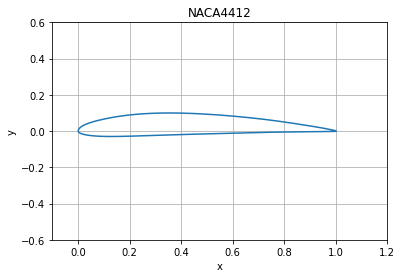

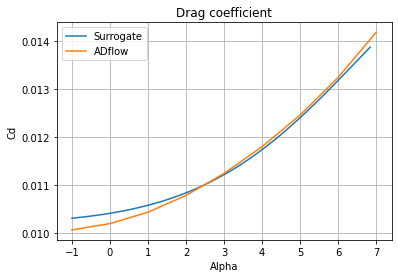

In [ ]:
cd_pred, alpha, airfoil_name = graphPredictionsSMT(airfoil_modeshapes,"NACA4412", Ma, True,genn)